In [1]:
import pandas as  pd
import nibabel as nb
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from sklearn.ensemble import RandomForestClassifier
from sktree import ObliqueRandomForestClassifier, PatchObliqueRandomForestClassifier
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
import pickle
import scipy.stats as ss

In [2]:
df = pd.read_excel('/cis/home/jdey4/data_MRI/subjects_age_sex_data_MRI.xlsx')
df.head()

,ID,Age,Sex,Dataset,Dataset-ID
0,sub-ABIDE1050339,18.0000,MALE,ABIDE,50339
1,sub-ABIDE1050701,18.0000,MALE,ABIDE,50701
2,sub-ABIDE1050445,18.1383,MALE,ABIDE,50445
3,sub-ABIDE1050459,18.1547,MALE,ABIDE,50459
4,sub-ABIDE1050341,18.2000,FEMALE,ABIDE,50341


In [3]:
df_quality = pd.read_csv('/cis/home/jdey4/data_MRI/QC_catreport.csv')
df_quality.head()

,sub,Weighted average (IQR),Warning
0,sub-A00008326,83.86,0
1,sub-A00008399,83.3,0
2,sub-A00010893,78.3,0
3,sub-A00013809,79.36,0
4,sub-A00018030,84.05,0


### Load data and build (feature, label)

In [4]:
path = '/cis/home/jdey4/data_MRI/'
subjects = os.listdir(path)
X = []
y = []
file_no = 0
count = 0
count_ = 0
IDs = set(df['ID'])
quality_ID = set(df_quality['sub'])
for subject in tqdm(subjects):
    if subject in IDs and subject in quality_ID:
        #print(df[df['ID']==subject]['Sex'])
        IQR = list(df_quality[df_quality['sub']==subject]['Weighted average (IQR)'])[0]
        count += 1
        #print(IQR)
        if IQR is np.nan:
            continue
            
        if IQR[-1] == '%':
            continue
        
        if float(IQR) < 60:
            continue

        count_ += 1
        #print(count, count_)
        gender = list(df[df['ID']==subject]['Sex'])
        sex = int(gender[0]=='FEMALE')
        
        
        current_file = os.path.join(path, subject)
        file_count = 0
        files = glob.glob(current_file+'/mri/*')

        for file in files:
            if 'mwp1' in file:
                try:
                    img = nb.load(file).get_fdata()
                    file_count +=1 
                except:
                    break
                
        for file in files:
            if 'mwp2' in file:
                try:
                    img = np.concatenate((img, nb.load(file).get_fdata()),axis=0)
                    file_count +=1 
                except:
                    break
                

        '''if len(tmp)<2:
            print(subject, ' has less files')'''
           
        if file_count==2:
            X.append(img.reshape(1,-1))
            y.append(sex)

    
X = np.concatenate(X,axis=0)

  9%|██████                                                                 | 1236/14471 [07:38<1:21:52,  2.69it/s]


KeyboardInterrupt: 

In [ ]:
len(X)

In [ ]:
X.shape

In [ ]:
np.mean(y)

In [ ]:
slice = 39
fig, ax = plt.subplots(1,1, figsize=(16,8))
ax.imshow(X[0].reshape(113*2,137,113)[:,:,slice])

In [ ]:
total_models = 1
idx = list(range(len(y)))

np.random.seed(0)
np.random.shuffle(idx)
train_samples = int(len(y)*0.8)
test_samples = len(y) - train_samples
train_ids = idx[:train_samples]

for ii in tqdm(range(total_models)):
    np.random.seed(ii)
    np.random.shuffle(train_ids)
    idx_chosen = train_ids[:int(len(y)*0.8*0.7)]
    
    rf = RandomForestClassifier(n_estimators=1, n_jobs=-1)
    rf.fit(X[idx_chosen], y[idx_chosen])

In [7]:
with open('morf_models/model0.pickle','rb') as f:
    rf = pickle.load(f)

In [13]:
a = rf.estimators_[0].tree_.get_projection_matrix()

In [21]:
a.shape

(433, 3498706)

## Train MORF

In [18]:
total_models = 200
idx = list(np.range(len(y)))

np.random.seed(0)
np.random.shuffle(idx)
train_samples = int(len(y)*0.8)
test_samples = len(y) - train_samples
train_ids = idx[:train_samples]

for ii in tqdm(range(total_models)):
    np.random.seed(ii)
    np.random.shuffle(train_ids)
    idx_chosen = train_ids[:int(len(y)*0.8*0.7)]
    
    morf = PatchObliqueRandomForestClassifier(n_estimators=1, max_patch_dims=np.array((3, 3, 3)), data_dims=np.array((113*2, 137, 113)), n_jobs=-1)
    morf.fit(X[idx_chosen], y_train[idx_chosen])

    with open('morf_models/model'+str(ii)+'.pickle','wb') as f:
        pickle.dump(morf, f)

    del morf

 66%|███████████████████████████████▊                | 664/1000 [12:59:53<6:34:38, 70.47s/it]


KeyboardInterrupt: 

In [13]:
total_models = 200
idx = list(np.range(len(y)))

np.random.seed(0)
np.random.shuffle(idx)
train_samples = int(len(y)*0.8)
test_samples = len(y) - train_samples
train_ids = idx[:train_samples]

predicted_proba_ = []
total_models = 650
for ii in tqdm(range(total_models)):
    with open('morf_models/model'+str(ii)+'.pickle','rb') as f:
        morf = pickle.load(f)
        predicted_proba_.append(
            morf.predict_proba(x_test[:,:113*137*113])
        )
        del morf

predicted_proba = np.mean(predicted_proba_,axis=0)
predicted_label = np.argmax(predicted_proba,axis=1)
print('MORF accuracy', np.mean(predicted_label==y_test))

MORF accuracy 0.8642533936651584


## Train MORF with shuffled label

In [14]:
total_models = 650
x_train_, x_test, y_train_, y_test = train_test_split(
                        X, y, train_size=.8,random_state=0, stratify=y)
for ii in tqdm(range(total_models)):
    x_train, _, y_train, _ = train_test_split(
                        x_train_, y_train_, train_size=.7,random_state=ii, stratify=y_train_)

    random.shuffle(y_train)
    morf = PatchObliqueRandomForestClassifier(n_estimators=1, max_patch_dims=np.array((4, 4, 4)), data_dims=np.array((2*113, 137, 113)), n_jobs=-1)
    morf.fit(x_train, y_train)

    with open('morf_shuffled_models/model'+str(ii)+'.pickle','wb') as f:
        pickle.dump(morf, f)

    del morf

100%|██████████████████████████████████████████████████████████| 650/650 [13:46:30<00:00, 76.29s/it]


### Find the feature importance

In [13]:
total_models = 650
feature_imp = []
for ii in tqdm(range(total_models)):
    with open('morf_models/model'+str(ii)+'.pickle','rb') as f:
        morf = pickle.load(f)
        feature_imp.append(
            morf.feature_importances_
        )
        del morf

for ii in tqdm(range(total_models)):
    with open('morf_shuffled_models/model'+str(ii)+'.pickle','rb') as f:
        morf = pickle.load(f)
        feature_imp.append(
            morf.feature_importances_
        )
        del morf

'''with open('feature_imp.pickle','wb') as f:
    pickle.dump(feature_imp, f)'''

100%|█████████████████████████████████████████████████████████████████| 200/200 [6:57:08<00:00, 125.14s/it]


"with open('feature_imp.pickle','wb') as f:\n    pickle.dump(feature_imp, f)"

In [42]:
feature_imp = np.array(feature_imp)

In [15]:
with open('feature_imp.pickle','wb') as f:
    pickle.dump(feature_imp, f)

In [50]:
reps = 100

r = ss.rankdata(
            np.mean(feature_imp[:total_models],axis=0), method='max'
        )
r_0 = ss.rankdata(
            np.mean(feature_imp[total_models:],axis=0), method='max'
        )

stat = (r_0 - r)

count = np.zeros(len(feature_imp[0]))
for _ in tqdm(range(reps)):
    idx = list(range(2*total_models))
    random.shuffle(idx)
    
    r1 = ss.rankdata(
                np.mean(feature_imp[idx[:total_models]],axis=0), method='max'
            )
    r1_0 = ss.rankdata(
                np.mean(feature_imp[idx[total_models:]],axis=0), method='max'
            )
    
    stat1 = (r1_0 - r1)
        
    count += (stat1>=stat)*1

p_val = (1 + count)/(1+reps)

100%|████████████████████████████████████████████████████████████████████████| 100/100 [14:27<00:00,  8.67s/it]


In [20]:
stat

array([-123694, -123694, -123694, ..., -123694, -123694, -123694])

In [22]:
np.sort(stat1)

array([-484884, -484881, -484820, ...,  489554,  489621,  489734])

In [8]:
with open('feature_imp.pickle','rb') as f:
    feature_imp = pickle.load(f)

total_models = 200

In [ ]:
reps = 1000

stat = np.zeros(len(feature_imp[0]))
for ii in range(total_models):
    r = ss.rankdata(
            1-feature_imp[ii], method='max'
        )
    r_0 = ss.rankdata(
            1-feature_imp[total_models+ii], method='max'
        )

    stat += (r_0 > r)*1

stat /= total_models

count = np.zeros(len(feature_imp[0]))
for _ in tqdm(range(reps)):
    idx = list(range(2*total_models))
    random.shuffle(idx)
    stat1 = np.zeros(len(feature_imp[0]))
    
    for ii in range(total_models):
        r1 = ss.rankdata(
                1-feature_imp[idx[ii]], method='max'
            )
        r1_0 = ss.rankdata(
                1-feature_imp[idx[total_models+ii]], method='max'
            )
    
        stat1 += (r1_0 > r1)*1

    stat1 /= total_models
    count += (stat1>=stat)*1

p_val = (1 + count)/(1+reps)

 69%|████████████████████████████████████████████████▏                     | 689/1000 [14:37:56<6:08:32, 71.10s/it]

In [ ]:
'''id_accept = np.where(p_val>0.05)[0]
id_reject = np.where(p_val<=0.05)[0]

feature_map = np.zeros(len(feature_imp[0]))
feature_map[id_reject] = 1'''
feature_map = -np.log(p_val)

In [11]:
demo_filepath_whitematter = '/cis/home/jdey4/data_MRI/sub-A00008326/mri/mwp2sub-A00008326_T1w.nii'
demo_filepath_graymatter = '/cis/home/jdey4/data_MRI/sub-A00008326/mri/mwp1sub-A00008326_T1w.nii'

img_whitematter = nb.load(demo_filepath_whitematter).get_fdata()
img_graymatter = nb.load(demo_filepath_graymatter).get_fdata()

In [12]:
brain_img = feature_map.reshape(113*2,137,113)

In [13]:
brain_img_ = np.mean(feature_imp[:total_models],axis=0).reshape(113*2,137,113)

Text(0.5, 1.0, 'gray matter (Traverse)')

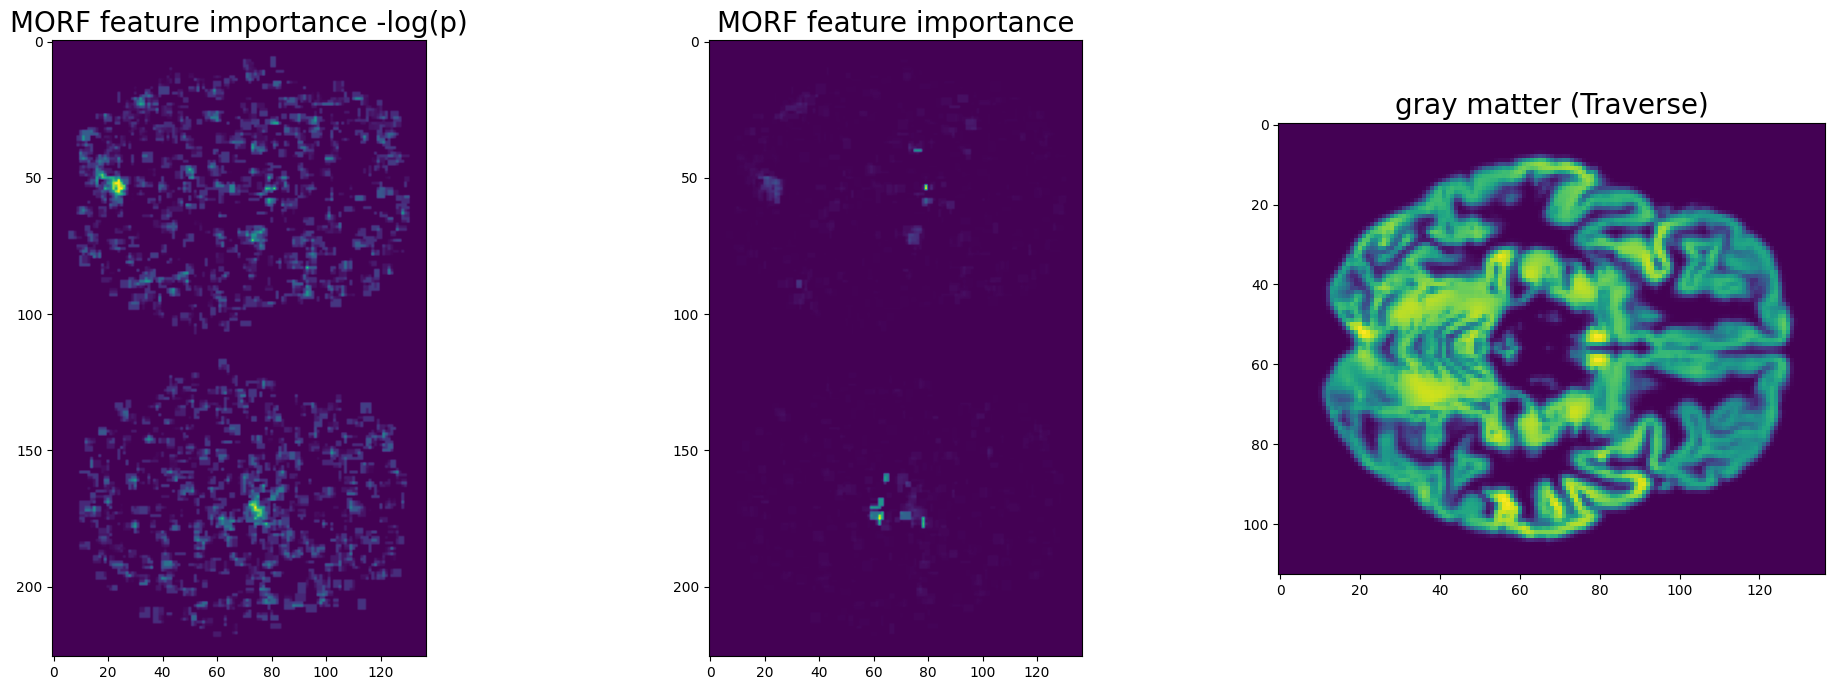

In [20]:
slice = 39

sliced_img_whitematter = img_whitematter[:,:,slice]
sliced_img_graymatter = img_graymatter[:,:,slice]

fig, ax = plt.subplots(1,3, figsize=(24,8))
ax[0].imshow(brain_img[:,:,slice])
ax[1].imshow(brain_img_[:,:,slice])
ax[2].imshow(sliced_img_graymatter)

ax[0].set_title('MORF feature importance -log(p)', fontsize=20)
ax[1].set_title('MORF feature importance', fontsize=20)
ax[2].set_title('gray matter (Traverse)', fontsize=20)

In [18]:
img_gray = nb.load(demo_filepath_graymatter)
img = nb.Nifti1Image(brain_img[:113,:,:], header = img_gray.header, affine = img_gray.affine)

nb.save(img, 'feature_imp_gray.nii')

In [19]:
img_gray = nb.load(demo_filepath_graymatter)
img = nb.Nifti1Image(brain_img[113:,:,:], header = img_gray.header, affine = img_gray.affine)

nb.save(img, 'feature_imp_white.nii')

In [17]:
np.sort(p_val)[:200]

array([0.00990099, 0.00990099, 0.00990099, 0.00990099, 0.00990099,
       0.00990099, 0.00990099, 0.00990099, 0.00990099, 0.00990099,
       0.00990099, 0.00990099, 0.00990099, 0.00990099, 0.00990099,
       0.00990099, 0.00990099, 0.00990099, 0.00990099, 0.00990099,
       0.00990099, 0.00990099, 0.00990099, 0.00990099, 0.00990099,
       0.00990099, 0.00990099, 0.00990099, 0.00990099, 0.00990099,
       0.00990099, 0.00990099, 0.00990099, 0.00990099, 0.00990099,
       0.00990099, 0.00990099, 0.00990099, 0.00990099, 0.00990099,
       0.00990099, 0.00990099, 0.00990099, 0.00990099, 0.00990099,
       0.00990099, 0.00990099, 0.00990099, 0.00990099, 0.00990099,
       0.00990099, 0.00990099, 0.00990099, 0.00990099, 0.00990099,
       0.00990099, 0.00990099, 0.00990099, 0.00990099, 0.00990099,
       0.00990099, 0.00990099, 0.00990099, 0.00990099, 0.00990099,
       0.00990099, 0.00990099, 0.00990099, 0.00990099, 0.00990099,
       0.00990099, 0.00990099, 0.00990099, 0.00990099, 0.00990

(array([  11351.,   16307.,   28649.,   13024.,   57801.,   63065.,
          32777.,   74499.,   63955., 1387925.]),
 array([0.00990099, 0.10891089, 0.20792079, 0.30693069, 0.40594059,
        0.5049505 , 0.6039604 , 0.7029703 , 0.8019802 , 0.9009901 ,
        1.        ]),
 <BarContainer object of 10 artists>)

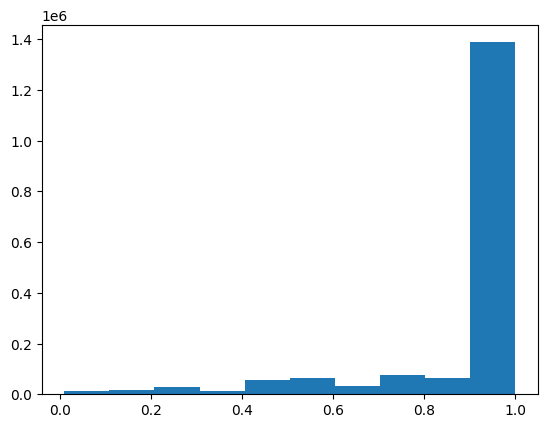

In [69]:
plt.hist(p_val)

In [9]:
import numpy as np
y = [0,1,2,3,4,5,6,7,8,9,10]
np.random.seed(0)
np.random.shuffle(y)

In [5]:
y_ = y[:6]
np.random.shuffle(y_)

In [6]:
y_

[4, 0, 3, 8, 10, 6]

In [10]:
y

[4, 9, 2, 10, 6, 1, 7, 8, 3, 0, 5]

In [11]:
int(len(y)*0.8)

8

In [12]:
X = np.ones((3,3))

In [14]:
X[[1,2]]

array([[1., 1., 1.],
       [1., 1., 1.]])

## Todos
1. git issue: p value
2. Git issue: morf save space
3. do ting thing with more data
4. do it on primates
5. bonferroni holm correction
6. check morf feature importance

In [27]:
stat.shape

(1749353,)

### Things that can be done

1. find a one-to-one mapping for mri to compress
2. find the slices that are important (any slice > chance is important) and only use them

### Todos
1. Do the PR
2. Do primates
3. profile the code
4. Check splitter